In [1]:
# --- 0. Setup & imports ---
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import math
import re
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 140

In [2]:
# --- 1. Paths & parameters ---
OUT_DIR   = Path(r"C:\Users\bseis\ABthesis\data\analysis")
CORE_PATH = Path(r"C:\Users\bseis\ABthesis\data\processed\crsp_weekly_core.parquet")  # for names

ASOF  = "20241227"
K     = 6
MINOV = 156
NORM  = "sqrt"

def _find_one(glob_pat: str) -> Path:
    hits = sorted(glob.iglob(str(OUT_DIR / glob_pat)))
    if not hits:
        raise FileNotFoundError(f"No file matches pattern: {glob_pat}")
    return Path(hits[-1])

base = f"nmi_tier1_asof{ASOF}_k{K}_min{MINOV}_{NORM}"
path_mi  = _find_one(f"mi_bits_*{base}.parquet")
path_nmi = _find_one(f"nmi_*{base}.parquet")
path_H   = _find_one(f"entropy_bits_*{base}.parquet")

print("[Paths]\n", path_mi, "\n", path_nmi, "\n", path_H)


[Paths]
 C:\Users\bseis\ABthesis\data\analysis\mi_bits_nmi_tier1_asof20241227_k6_min156_sqrt.parquet 
 C:\Users\bseis\ABthesis\data\analysis\nmi_nmi_tier1_asof20241227_k6_min156_sqrt.parquet 
 C:\Users\bseis\ABthesis\data\analysis\entropy_bits_nmi_tier1_asof20241227_k6_min156_sqrt.parquet


In [3]:
# --- 2. Build name mapping from core panel (as-of latest date for stable names) ---
panel = pd.read_parquet(CORE_PATH)
panel["date"] = pd.to_datetime(panel["date"])
panel["permno"] = pd.to_numeric(panel["permno"], errors="coerce").astype("Int64")

ASOF_DATE = panel["date"].max()
asof_info = (panel[panel["date"].eq(ASOF_DATE)]
             .sort_values(["permno","date"])
             .drop_duplicates("permno", keep="last")
             [["permno","ticker","comnam"]]
             .copy())

def _label_from_row(r):
    t = (str(r.get("ticker") or "")).strip().upper()
    n = (str(r.get("comnam") or "")).strip()
    if t and t != "NAN":
        return f"{t} — {n}" if n and n != "NAN" else t
    return n if n and n != "NAN" else f"PERMNO_{int(r['permno'])}"

asof_info["label"] = asof_info.apply(_label_from_row, axis=1)
PERMNO_TO_NAME = dict(zip(asof_info["permno"].astype(int), asof_info["label"]))
len(PERMNO_TO_NAME), list(PERMNO_TO_NAME.items())[:3]


(1456,
 [(10026, 'JJSF — J & J SNACK FOODS CORP'),
  (10032, 'PLXS — PLEXUS CORP'),
  (10104, 'ORCL — ORACLE CORP')])

In [4]:
# --- 3. Load MI/NMI/H and rename indices to company names ---
R_mi  = pd.read_parquet(path_mi)   # square
R_nmi = pd.read_parquet(path_nmi)  # square
H     = pd.read_parquet(path_H)

# Normalize H to Series
if isinstance(H, pd.DataFrame):
    if H.shape[1] != 1:
        H = H.iloc[:, [0]]
    H = H.iloc[:, 0]
H.name = "entropy_bits"

# Helper: parse PERMNO from index label if it isn't a pure int (e.g., "AAPL_14593")
def _parse_permno(label) -> int | None:
    # try direct int
    try:
        return int(label)
    except Exception:
        pass
    # common patterns: "AAPL_14593", "AAPL — Apple Inc._14593"
    m = re.search(r"(\d{4,7})$", str(label))
    return int(m.group(1)) if m else None

# Build a mapping from current matrix labels to names
idx_labels = pd.Index(R_nmi.index)
label_to_name = {}

for lab in idx_labels:
    p = _parse_permno(lab)
    if p is not None and p in PERMNO_TO_NAME:
        label_to_name[lab] = PERMNO_TO_NAME[p]
    else:
        # fallbacks: try ticker/comnam already provided
        s = str(lab)
        label_to_name[lab] = s  # keep as-is if we can't improve it

# Apply mapping
R_mi_named  = R_mi.rename(index=label_to_name, columns=label_to_name)
R_nmi_named = R_nmi.rename(index=label_to_name, columns=label_to_name)
H_named     = H.copy()
H_named.index = H_named.index.map(lambda lab: label_to_name.get(lab, lab))

# Ensure synchronized order
R_mi_named  = R_mi_named.loc[R_mi_named.index, R_mi_named.index]
R_nmi_named = R_nmi_named.loc[R_nmi_named.index, R_nmi_named.index]

print("Shapes → MI:", R_mi_named.shape, "| NMI:", R_nmi_named.shape)
print("Index sample:", list(R_nmi_named.index[:5]))


Shapes → MI: (1000, 1000) | NMI: (1000, 1000)
Index sample: ['PLXS — PLEXUS CORP', 'ORCL — ORACLE CORP', 'MSFT — MICROSOFT CORP', 'TROW — T ROWE PRICE GROUP INC', 'HON — HONEYWELL INTERNATIONAL INC']


In [5]:
# --- 4. QA: symmetry & diagonal ---
mi_asym  = float(np.nanmax(np.abs(R_mi_named.values  - R_mi_named.values.T)))
nmi_asym = float(np.nanmax(np.abs(R_nmi_named.values - R_nmi_named.values.T)))
print(f"Max asymmetry | MI: {mi_asym:.3e} | NMI: {nmi_asym:.3e}")

nmi_diag = np.diag(R_nmi_named.values)
print("NMI diag (min/median/max):",
      np.nanmin(nmi_diag), np.nanmedian(nmi_diag), np.nanmax(nmi_diag))


Max asymmetry | MI: 0.000e+00 | NMI: 0.000e+00
NMI diag (min/median/max): 1.0 1.0 1.0


In [6]:
# --- 5. Helpers ---
def upper_tri(M: pd.DataFrame) -> np.ndarray:
    A = M.values
    iu = np.triu_indices_from(A, k=1)
    return A[iu]

def summarize_offdiag(M: pd.DataFrame, label=""):
    v = upper_tri(M)
    v = v[np.isfinite(v)]
    if len(v) == 0:
        print(f"[{label}] No finite off-diagonals.")
        return
    neg  = (v < 0).mean()*100
    zero = (v == 0).mean()*100
    print(f"[{label}] pairs={len(v):,} | neg={neg:.2f}% | zero={zero:.2f}% | "
          f"mean={np.nanmean(v):.6f} | med={np.nanmedian(v):.6f} | "
          f"p1={np.nanpercentile(v,1):.6f} | p5={np.nanpercentile(v,5):.6f} | "
          f"p95={np.nanpercentile(v,95):.6f} | p99={np.nanpercentile(v,99):.6f}")


In [7]:
# --- 6. Global summaries ---
summarize_offdiag(R_mi_named,  "MI (bits)")
summarize_offdiag(R_nmi_named, "NMI")


[MI (bits)] pairs=476,776 | neg=5.51% | zero=0.00% | mean=0.144513 | med=0.127107 | p1=-0.055779 | p5=-0.003661 | p95=0.346341 | p99=0.504593
[NMI] pairs=476,776 | neg=5.51% | zero=0.00% | mean=0.045955 | med=0.040424 | p1=-0.017720 | p5=-0.001163 | p95=0.110128 | p99=0.160407


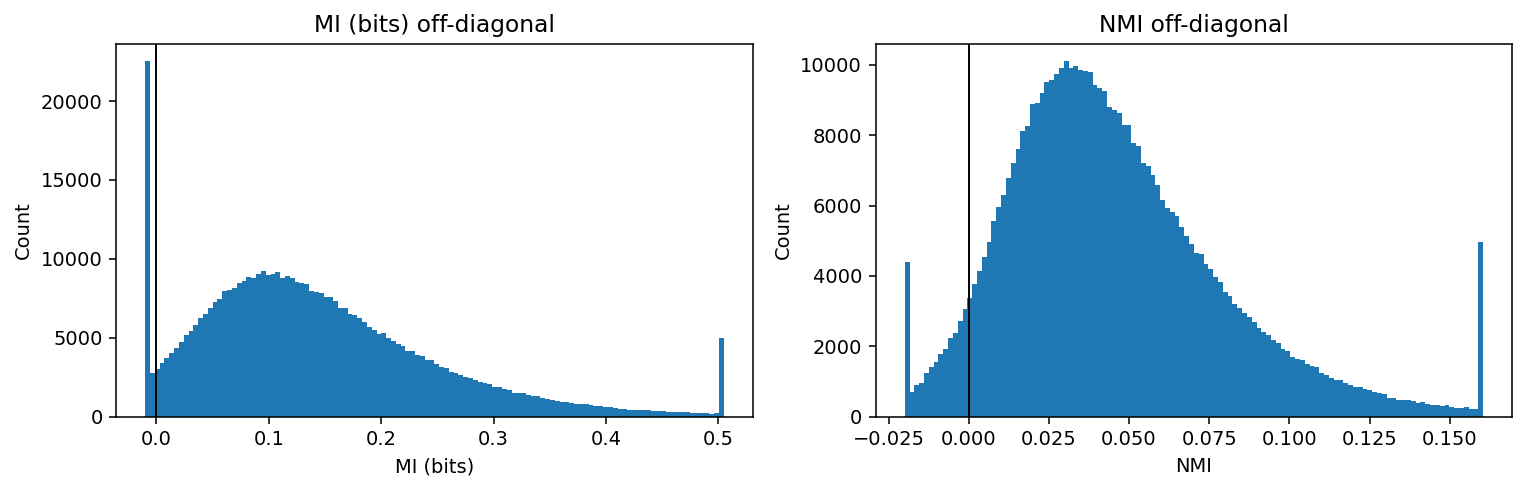

In [8]:
# --- 7. Histograms ---
mi_vals  = upper_tri(R_mi_named);  mi_vals  = mi_vals[np.isfinite(mi_vals)]
nmi_vals = upper_tri(R_nmi_named); nmi_vals = nmi_vals[np.isfinite(nmi_vals)]

fig, axes = plt.subplots(1, 2, figsize=(11,3.6))

clip_hi_mi = np.nanpercentile(mi_vals, 99.0)
axes[0].hist(np.clip(mi_vals, -0.01, clip_hi_mi), bins=120)
axes[0].axvline(0, color="black", lw=1)
axes[0].set_title("MI (bits) off-diagonal"); axes[0].set_xlabel("MI (bits)"); axes[0].set_ylabel("Count")

clip_hi = np.nanpercentile(nmi_vals, 99.0)
axes[1].hist(np.clip(nmi_vals, -0.02, clip_hi), bins=120)
axes[1].axvline(0, color="black", lw=1)
axes[1].set_title("NMI off-diagonal"); axes[1].set_xlabel("NMI"); axes[1].set_ylabel("Count")

plt.tight_layout(); plt.show()


In [9]:
# --- 8. Top & bottom NMI pairs (named) ---
A = R_nmi_named.values
names = R_nmi_named.index.to_list()
iu = np.triu_indices_from(A, k=1)

pairs = pd.DataFrame({
    "i": [names[i] for i in iu[0]],
    "j": [names[j] for j in iu[1]],
    "NMI": A[iu],
    "MI_bits": R_mi_named.values[iu],
}).dropna(subset=["NMI","MI_bits"])

TOP_K = 30
top_pairs = pairs.sort_values("NMI", ascending=False).head(TOP_K)
print("Top NMI pairs:"); display(top_pairs.reset_index(drop=True))

if (pairs["NMI"] < 0).any():
    worst = pairs.sort_values("NMI", ascending=True).head(min(TOP_K, (pairs["NMI"] < 0).sum()))
    print("Most negative NMI pairs:"); display(worst.reset_index(drop=True))
else:
    print("No negative NMI pairs.")


Top NMI pairs:


,i,j,NMI,MI_bits
0,CHTR — CHARTER COMMUNICATIONS INC NEW,LBRDK — LIBERTY BROADBAND CORP,0.743323,2.339854
1,CFG — CITIZENS FINANCIAL GROUP INC,KEY — KEYCORP NEW,0.543524,1.709565
2,CFG — CITIZENS FINANCIAL GROUP INC,RF — REGIONS FINANCIAL CORP NEW,0.539746,1.697681
3,CFG — CITIZENS FINANCIAL GROUP INC,FITB — FIFTH THIRD BANCORP,0.539602,1.697229
4,CFG — CITIZENS FINANCIAL GROUP INC,HBAN — HUNTINGTON BANCSHARES INC,0.538252,1.692984
5,CFG — CITIZENS FINANCIAL GROUP INC,CMA — COMERICA INC,0.492105,1.547837
6,MA — MASTERCARD INC,V — VISA INC,0.475194,1.494375
7,MUR — MURPHY OIL CORP,89134,0.472113,1.486240
8,CFG — CITIZENS FINANCIAL GROUP INC,PNC — P N C FINANCIAL SERVICES GRP INC,0.468839,1.474655
9,MET — METLIFE INC,PRU — PRUDENTIAL FINANCIAL INC,0.455327,1.430906


Most negative NMI pairs:


,i,j,NMI,MI_bits
0,21559,HAS — HASBRO INC,-0.078736,-0.247916
1,LPLA — L P L FINANCIAL HOLDINGS INC,19413,-0.068500,-0.215828
2,ARMK — ARAMARK,21747,-0.068378,-0.215543
3,PEP — PEPSICO INC,20357,-0.064983,-0.204603
4,21896,K — KELLOGG CO,-0.062765,-0.197629
5,CVS — C V S HEALTH CORP,20892,-0.062633,-0.197209
6,22084,PEG — PUBLIC SERVICE ENTERPRISE GP INC,-0.061388,-0.193295
7,21747,HAS — HASBRO INC,-0.060698,-0.191121
8,XOM — EXXON MOBIL CORP,18938,-0.059645,-0.187796
9,GIS — GENERAL MILLS INC,19794,-0.059510,-0.187361


,i_name,j_name,NMI,MI_bits
0,CHTR — CHARTER COMMUNICATIONS INC NEW,LBRDK — LIBERTY BROADBAND CORP,0.743323,2.339854
1,CFG — CITIZENS FINANCIAL GROUP INC,KEY — KEYCORP NEW,0.543524,1.709565
2,CFG — CITIZENS FINANCIAL GROUP INC,RF — REGIONS FINANCIAL CORP NEW,0.539746,1.697681
3,CFG — CITIZENS FINANCIAL GROUP INC,FITB — FIFTH THIRD BANCORP,0.539602,1.697229
4,CFG — CITIZENS FINANCIAL GROUP INC,HBAN — HUNTINGTON BANCSHARES INC,0.538252,1.692984
5,CFG — CITIZENS FINANCIAL GROUP INC,CMA — COMERICA INC,0.492105,1.547837
6,MA — MASTERCARD INC,V — VISA INC,0.475194,1.494375
7,MUR — MURPHY OIL CORP,89134,0.472113,1.486240
8,CFG — CITIZENS FINANCIAL GROUP INC,PNC — P N C FINANCIAL SERVICES GRP INC,0.468839,1.474655
9,MET — METLIFE INC,PRU — PRUDENTIAL FINANCIAL INC,0.455327,1.430906


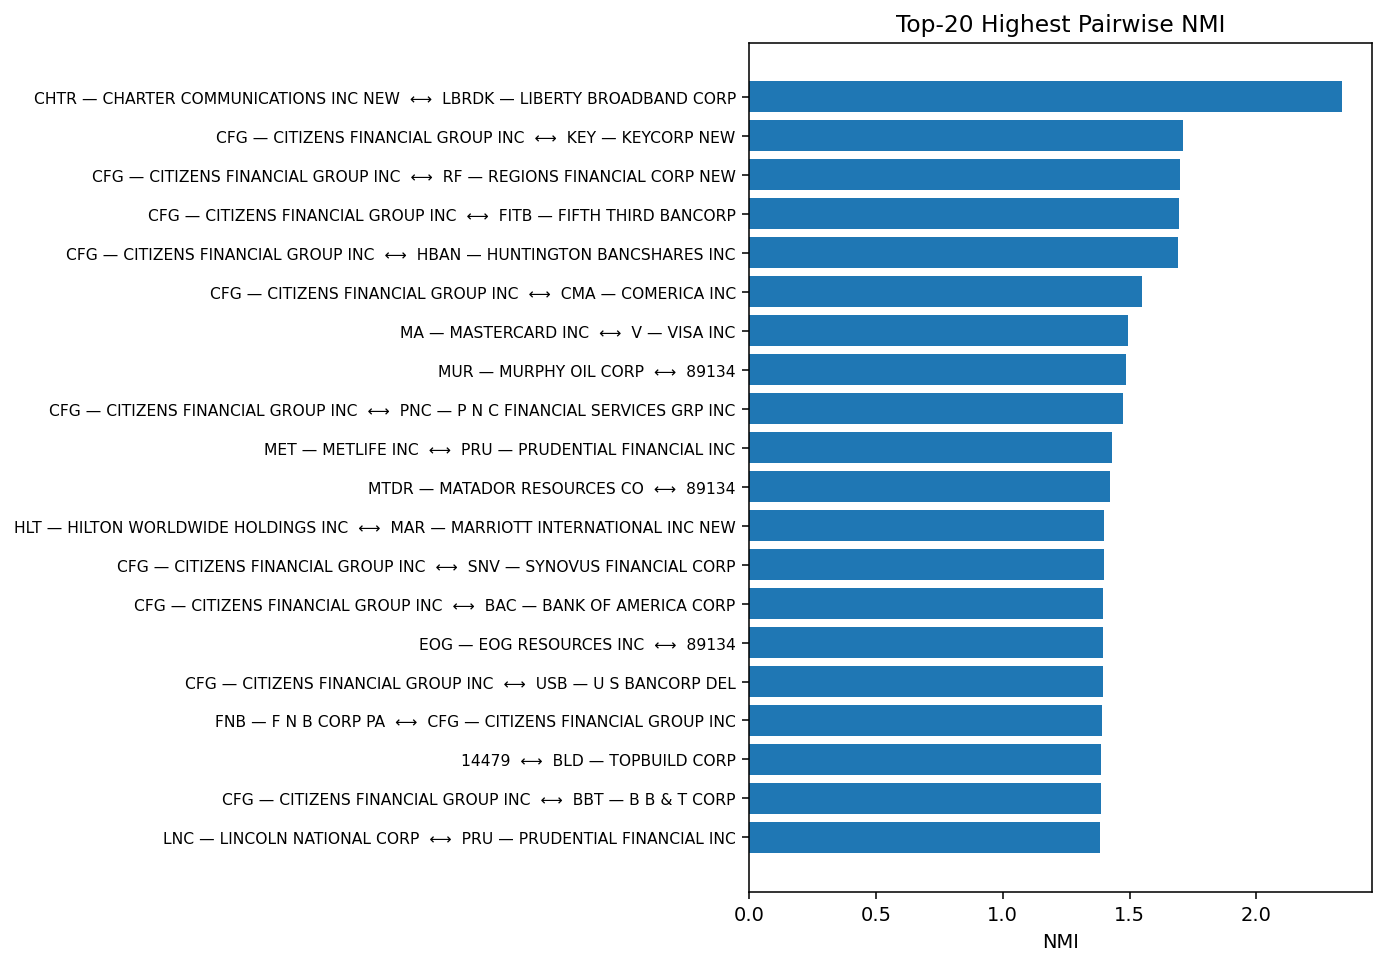

In [10]:
# === Top-20 HIGHEST pairwise NMI across the whole matrix ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use the named matrices loaded earlier: R_nmi_named, R_mi_named
A_nmi = R_nmi_named.values
A_mi  = R_mi_named.values
names = R_nmi_named.index.to_list()

# Upper triangle indices (i < j) to avoid duplicates and diagonal
iu = np.triu_indices_from(A_nmi, k=1)

# Build an edge list
pairs_df = pd.DataFrame({
    "i_name": [names[i] for i in iu[0]],
    "j_name": [names[j] for j in iu[1]],
    "NMI":    A_nmi[iu],
    "MI_bits": A_mi[iu],
})

# Drop non-finite rows (NaN/inf)
pairs_df = pairs_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["NMI", "MI_bits"])

# Sort by NMI descending and take the top 20
TOPK = 20
top_pairs = pairs_df.sort_values("MI_bits", ascending=False).head(TOPK).reset_index(drop=True)

# Pretty display
pd.options.display.float_format = "{:.6f}".format
display(top_pairs)

# Bar chart of the top 20 pairs
labels = [f"{row.i_name}  ⟷  {row.j_name}" for row in top_pairs.itertuples(index=False)]
plt.figure(figsize=(10, 7))
plt.barh(range(TOPK), top_pairs["MI_bits"].values, color="tab:blue")
plt.yticks(range(TOPK), labels, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("NMI")
plt.title("Top-20 Highest Pairwise NMI")
plt.tight_layout()
plt.show()

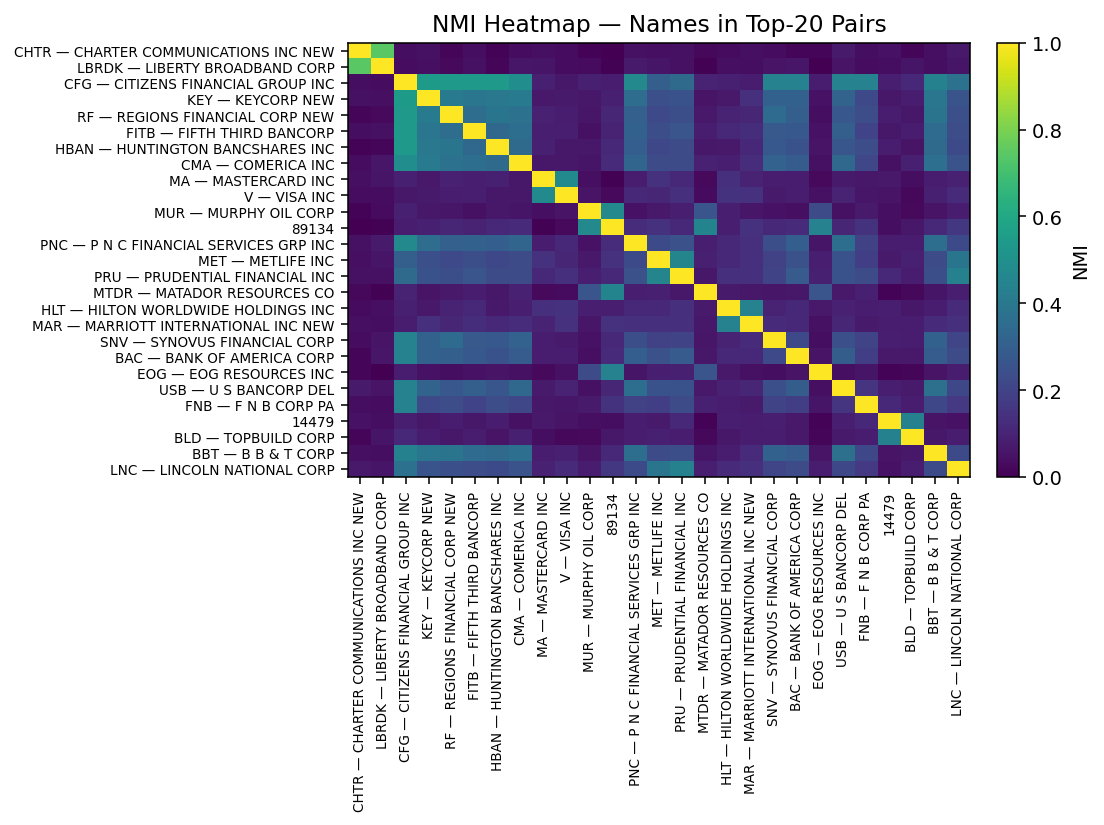

In [11]:
# Heatmap for the subgraph of those 20 pairs (unique names involved)
uniq = pd.Index(pd.unique(top_pairs[["i_name","j_name"]].values.ravel()))
Rn_sub = R_nmi_named.loc[uniq, uniq]

plt.figure(figsize=(8, 6))
im = plt.imshow(Rn_sub.values, interpolation="nearest", aspect="auto",
                vmin=0, vmax=np.nanpercentile(Rn_sub.values, 99))
plt.colorbar(im, fraction=0.046, pad=0.04, label="NMI")
plt.xticks(range(len(uniq)), uniq, rotation=90, fontsize=7)
plt.yticks(range(len(uniq)), uniq, fontsize=7)
plt.title("NMI Heatmap — Names in Top-20 Pairs")
plt.tight_layout(); plt.show()

In [13]:
# --- 10. Heatmaps with names ---
FOCUS_N = 1000
focus_names = node_summary.index[:FOCUS_N]
Rn_focus = R_nmi_named.loc[focus_names, focus_names]

plt.figure(figsize=(8.5,7.5))
im = plt.imshow(Rn_focus.values, interpolation="nearest", aspect="auto",
                vmin=0, vmax=np.nanpercentile(upper_tri(Rn_focus), 99))
plt.colorbar(im, fraction=0.046, pad=0.04, label="NMI")
plt.title(f"NMI heatmap (top-{FOCUS_N} by mean NMI)")

ticks = np.arange(len(Rn_focus))
plt.xticks(ticks, [str(s) for s in Rn_focus.columns], rotation=90, fontsize=6)
plt.yticks(ticks, [str(s) for s in Rn_focus.index], fontsize=6)
plt.tight_layout(); plt.show()


NameError: name 'node_summary' is not defined

In [16]:
import numpy as np, pandas as pd
from numpy.linalg import eigvalsh

# Always start from ONE source and sanitize once
Q_raw = R_nmi_named.copy()                 # <- your named NMI matrix
Q = Q_raw.to_numpy(dtype="float64", copy=True)

# Replace any non-finite values deterministically
mask_bad = ~np.isfinite(Q)
print("bad entries:", int(mask_bad.sum()))
if mask_bad.any():
    # NMI should be in [0,1]; treat bad as 0 redundancy
    Q[mask_bad] = 0.0

# Enforce bounds & symmetry & zero diagonal
Q = np.clip(Q, 0.0, 1.0)
Q = 0.5*(Q + Q.T)
np.fill_diagonal(Q, 0.0)

# Double-check after cleaning
mask_bad2 = ~np.isfinite(Q)
print("bad AFTER clean:", int(mask_bad2.sum()),
      "| symmetry err:", float(np.max(np.abs(Q - Q.T))),
      "| diag min/max:", float(np.min(np.diag(Q))), float(np.max(np.diag(Q))))

# Quick spectrum probe (this MUST NOT be nan)
evals0 = eigvalsh(Q)
print("eig min/med/max (raw sym):", float(np.min(evals0)),
      float(np.median(evals0)), float(np.max(evals0)))


bad entries: 45448
bad AFTER clean: 0 | symmetry err: 0.0 | diag min/max: 0.0 0.0
eig min/med/max (raw sym): -3.391861754047349 -0.11144473552438523 51.39697378576113


In [18]:
from numpy.linalg import eigh

def nearest_psd(A, eps_eig=0.0):
    B = 0.5*(A + A.T)
    w, V = eigh(B)
    w = np.maximum(w, eps_eig)         # clip negs to eps_eig
    Bpsd = (V * w) @ V.T
    return 0.5*(Bpsd + Bpsd.T)

Q_psd = nearest_psd(Q, eps_eig=0.0)
w = eigvalsh(Q_psd)
print("PSD min eig:", float(w[0]), "| #<=1e-12:", int(np.sum(w <= 1e-12)))

# choose ridge to get decent conditioning
def choose_ridge(Qpsd, target_min=1e-6, kappa_max=1e8):
    w = eigvalsh(Qpsd)
    if (w[0] >= target_min) and (w[-1]/max(w[0],1e-16) <= kappa_max):
        return 0.0
    ridge = 1e-8
    for _ in range(12):
        w2 = eigvalsh(Qpsd + ridge*np.eye(Qpsd.shape[0]))
        if (w2[0] >= target_min) and (w2[-1]/w2[0] <= kappa_max):
            return ridge
        ridge *= 10
    return ridge

ridge = choose_ridge(Q_psd, target_min=1e-6, kappa_max=1e8)
Q_reg  = Q_psd + ridge*np.eye(Q_psd.shape[0])
w_reg  = eigvalsh(Q_reg)
print("ridge:", ridge, "| min eig:", float(w_reg[0]), "| cond~", float(w_reg[-1]/w_reg[0]))


PSD min eig: -4.74816594383607e-15 | #<=1e-12: 605
ridge: 9.999999999999999e-06 | min eig: 9.999999994554314e-06 | cond~ 5139698.381375022


In [19]:
from numpy.linalg import solve, lstsq, pinv, norm

names = R_nmi_named.index.to_list()
n = len(names)
ones = np.ones(n)

def robust_solve(Q, rhs, rcond=1e-10):
    try:
        return solve(Q, rhs)
    except np.linalg.LinAlgError:
        try:
            z, *_ = lstsq(Q, rhs, rcond=None)
            return z
        except Exception:
            return pinv(Q, rcond=rcond) @ rhs

z   = robust_solve(Q_reg, ones)
den = float(ones @ z)
if (not np.isfinite(den)) or (abs(den) < 1e-14):
    # bump ridge & retry if denominator degenerates
    ridge = max(ridge*10, 1e-6)
    Q_reg = Q_psd + ridge*np.eye(n)
    z     = robust_solve(Q_reg, ones)
    den   = float(ones @ z)

b_star = pd.Series(z/den, index=names)

def redundancy_value(b, Qm):
    v = b.values if isinstance(b, pd.Series) else b
    return 0.5 * float(v @ (Qm @ v))

print(f"Sum(b)={b_star.sum():.12f} | L1 leverage={np.sum(np.abs(b_star.values)):.3f} | D(b)={redundancy_value(b_star, Q_psd):.6e} | ridge={ridge}")


Sum(b)=1.000000000000 | L1 leverage=3.058 | D(b)=8.548805e-12 | ridge=9.999999999999999e-06


In [ ]:
# Cross check with CVXPY

import cvxpy as cp
b = cp.Variable(n)
prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(b, Q_reg)), [cp.sum(b)==1])
_ = prob.solve(solver="OSQP", verbose=False)  # ECOS also fine
b_cvx = pd.Series(np.array(b.value).ravel(), index=names)
print("||b_cvx - b_star||_2 =", norm(b_cvx.values - b_star.values))


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Basic stats
print(f"sum(b) = {b_star.sum():.6f}")
print(f"L1 leverage = {np.sum(np.abs(b_star.values)):.3f}")
print(f"#longs = {(b_star>0).sum()} | #shorts = {(b_star<0).sum()}")

# Top 20 longs/shorts (by magnitude)
top_longs  = b_star.sort_values(ascending=False).head(20)
top_shorts = b_star.sort_values(ascending=True).head(20)

display(top_longs.to_frame("weight"))
display(top_shorts.to_frame("weight"))

# Barh for top longs / shorts
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False)
top_longs.iloc[::-1].plot(kind="barh", ax=ax[0], color="tab:green")
ax[0].set_title("Top 20 Longs"); ax[0].set_xlabel("Weight")
top_shorts.iloc[::-1].plot(kind="barh", ax=ax[1], color="tab:red")
ax[1].set_title("Top 20 Shorts"); ax[1].set_xlabel("Weight")
plt.tight_layout(); plt.show()

# Histogram of weights (signed)
plt.figure(figsize=(6,4))
plt.hist(b_star.values, bins=60, color="tab:blue", alpha=0.8)
plt.title("Distribution of Portfolio Weights"); plt.xlabel("Weight"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


In [ ]:
w_abs = b_star.abs().sort_values(ascending=False)
cum_abs = w_abs.cumsum()
plt.figure(figsize=(6,4))
cum_abs.plot()
plt.title("Cumulative |weight| by name (sorted)")
plt.ylabel("Cumulative |weight|"); plt.xlabel("Name rank")
plt.tight_layout(); plt.show()

# Effective breadth (how many names account for X% of |w|)
for x in (0.5, 0.8, 0.9):
    k = int((cum_abs <= x).sum()) + 1
    print(f"~{x*100:.0f}% of |weights| is in the top ~{k} names")


In [ ]:
k_focus = 60  # take top 30 by |weight|
focus = b_star.abs().sort_values(ascending=False).head(k_focus).index
Q_focus = R_nmi_named.loc[focus, focus]

plt.figure(figsize=(7.5,6.5))
im = plt.imshow(Q_focus.values, interpolation="nearest", aspect="auto",
                vmin=0, vmax=np.nanpercentile(Q_focus.values, 99))
plt.colorbar(im, fraction=0.046, pad=0.04, label="NMI penalty")
plt.xticks(range(len(focus)), focus, rotation=90, fontsize=7)
plt.yticks(range(len(focus)), focus, fontsize=7)
plt.title(f"NMI (Q) among top-{k_focus} by |weight|")
plt.tight_layout(); plt.show()
